In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.linear_model import LogisticRegression


import ipywidgets as widgets
from IPython.display import display, clear_output


import seaborn as sns
import ipympl
from ipywidgets import widgets, VBox, HBox

import warnings

### What stats are historically most predictive of winning the championship? - Random Forest model
* Here we have many decision trees predict whether a given team will win the league and aggregate their predictions
* In doing so, we quantify which stats are most predictive of winning (below)

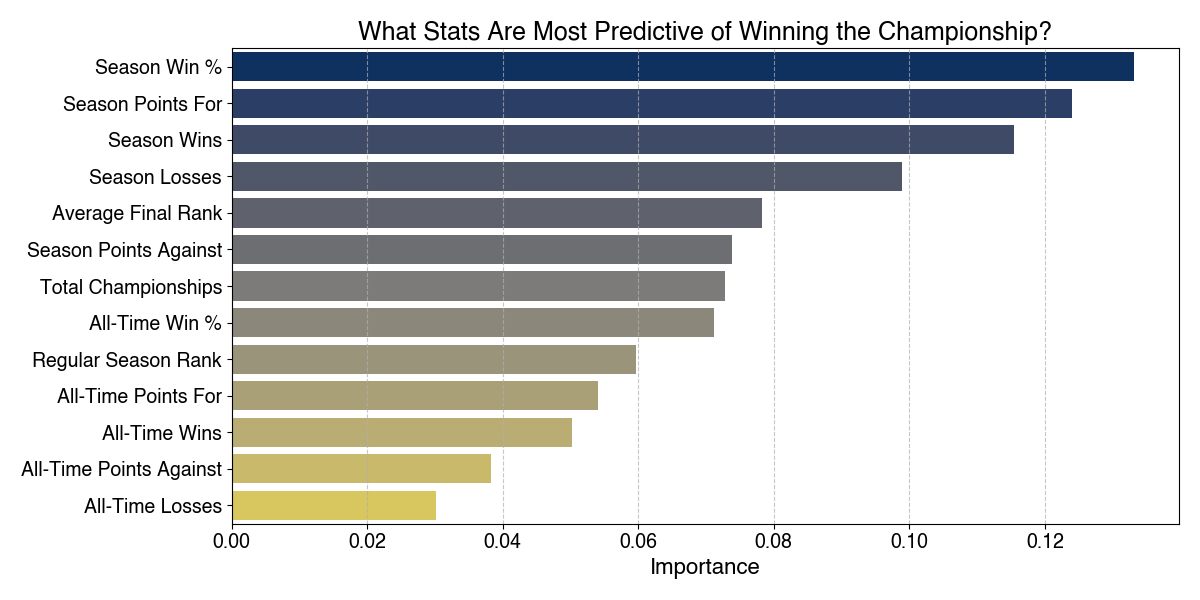

In [55]:

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
# Load dataset
df = pd.read_csv('full_league_history.csv')

# Aggregate at season level
final_week_df = df.groupby(['season', 'owner']).apply(lambda x: x.loc[x['week'].idxmax()]).reset_index(drop=True)

# Binarize target variable: 1 if champion, else 0
final_week_df['champion'] = (final_week_df['final_rank'] == 1).astype(int)

# All possible predictive measures
features = [
    'szn_pts_for', 'szn_pts_against', 'szn_wins', 'szn_losses', 'szn_pct', 
    'all_time_pts_for', 'all_time_pts_against', 'all_time_wins', 'all_time_losses', 
    'all_time_pct', 'reg_szn_rank', 'avg_final_rank', 'championships'
]

X = final_week_df[features]
y = final_week_df['champion']

# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model - data is unbalanced (much better at predicting non-winners, 
# but using "balanced" or changing decision threshold doesn't improve performance 
# much and converges all predictions to Owen which is less fun
model = RandomForestClassifier(n_estimators=100, random_state=77)
model.fit(X_train, y_train)

# Evaluate model performance
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
#print(f"\nTest Accuracy: {acc*100:.2f}%")

# cross validation scores and auc-roc scores
cv_scores = cross_val_score(model, X, y, cv=5)
#print("Cross-Validation Accuracy Scores:", cv_scores)
#print("Average CV Accuracy:", cv_scores.mean())

y_proba_cv = cross_val_predict(model, X, y, cv=5, method="predict_proba")[:, 1]
auc_score = roc_auc_score(y, y_proba_cv)
#print(f"AUC-ROC Score: {auc_score:.3f}")

# =============================================================================
# 6.FEATURE IMPORTANCE PLOT
# =============================================================================

# Extract feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

feature_labels = {
    "szn_pts_for": "Season Points For",
    "szn_pts_against": "Season Points Against",
    "szn_wins": "Season Wins",
    "szn_losses": "Season Losses",
    "szn_pct": "Season Win %",
    "all_time_pts_for": "All-Time Points For",
    "all_time_pts_against": "All-Time Points Against",
    "all_time_wins": "All-Time Wins",
    "all_time_losses": "All-Time Losses",
    "all_time_pct": "All-Time Win %",
    "reg_szn_rank": "Regular Season Rank",
    "avg_final_rank": "Average Final Rank",
    "championships": "Total Championships"
}
cleaned_feature_names = [feature_labels[feature] for feature in np.array(features)[indices]]


plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 14  


fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=importances[indices], y=cleaned_feature_names, palette='cividis', ax=ax)

ax.set_xlabel("Importance", fontsize=16)
ax.set_title("What Stats Are Most Predictive of Winning the Championship?", fontsize=18)

ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### Probabilities of winning championship based on stats by year

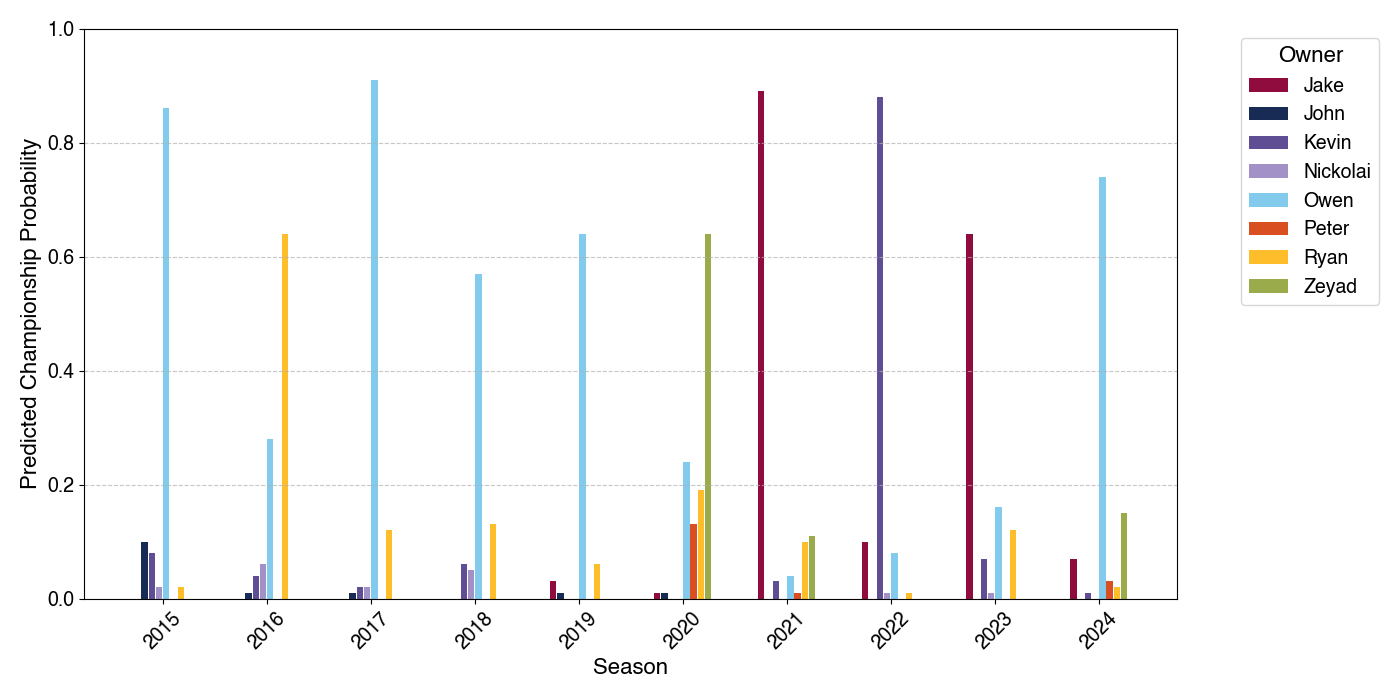

owner,Jake,John,Kevin,Nickolai,Owen,Peter,Ryan,Zeyad
season,,,,,,,,
2015,0.00,0.10,0.08,0.02,0.86,0.00,0.02,0.00
2016,0.00,0.01,0.04,0.06,0.28,0.00,0.64,0.00
2017,0.00,0.01,0.02,0.02,0.91,0.00,0.12,0.00
2018,0.00,0.00,0.06,0.05,0.57,0.00,0.13,0.00
2019,0.03,0.01,0.00,0.00,0.64,0.00,0.06,0.00
2020,0.01,0.01,0.00,0.00,0.24,0.13,0.19,0.64
2021,0.89,0.00,0.03,0.00,0.04,0.01,0.10,0.11
2022,0.10,0.00,0.88,0.01,0.08,0.00,0.01,0.00
2023,0.64,0.00,0.07,0.01,0.16,0.00,0.12,0.00


In [59]:

# =============================================================================
# 6. PREDICTING CHAMPIONSHIP PROBABILITIES & VISUALIZATION
# =============================================================================

# Get predicted probabilities for each (season, owner)
final_week_df['predicted_prob'] = model.predict_proba(X)[:, 1]

# Pivot the data so each season is a row and columns are owners with their predicted probabilities
prob_pivot = final_week_df.pivot(index='season', columns='owner', values='predicted_prob')


custom_hex_palette = [
    "#900c3f", "#182b55", "#5f4e94", "#a291c7",
    "#82cbec", "#d94f21", "#febd2b", "#9aab4b"
]

# color bars by owner
sorted_owners = sorted(prob_pivot.columns.tolist())
color_map = {owner: custom_hex_palette[i % len(custom_hex_palette)] for i, owner in enumerate(sorted_owners)}

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 14  

# Convert seasons to categorical values for better positioning
season_labels = sorted(prob_pivot.index.tolist())
x_indexes = np.arange(len(season_labels)) * 1.8 


bar_width = 0.11
num_owners = len(sorted_owners)
offsets = np.linspace(-bar_width * num_owners / 2, bar_width * num_owners / 2, num_owners)


fig, ax = plt.subplots(figsize=(14, 7))

# plot bars
for i, owner in enumerate(sorted_owners):
    values = prob_pivot[owner].values
    x_positions = x_indexes + offsets[i]  
    ax.bar(x_positions, values, width=bar_width, label=owner, color=color_map[owner])

ax.set_xlabel("Season", fontsize=16)
ax.set_ylabel("Predicted Championship Probability", fontsize=16)

ax.set_xticks(x_indexes)
ax.set_xticklabels(season_labels, rotation=45)

# constrain probablitiy from 0 to 100%
ax.set_ylim(0, 1)

ax.legend(title="Owner", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14, title_fontsize=16)

ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

# =============================================================================
# 7. DISPLAY FORMATTED TABLE
# =============================================================================

# function to use HTML styling on pandas df for presentation
def format_table(df, title):
    """Format a Pandas DataFrame into a nicely styled HTML table with color-coded owner names."""
    styles = """
        <style>
            table {
                width: 100%;
                border-collapse: collapse;
                font-family: Arial, sans-serif;
                font-size: 14px;
                background-color: #f5f5f5;
            }
            th {
                background-color: #182b55;
                color: white;
                font-weight: bold;
                padding: 10px;
                border: 1px solid #ccc;
                text-transform: capitalize;
                text-align: center;
            }
            td {
                padding: 8px;
                border: 1px solid #ccc;
                text-align: center;
            }
            tr:nth-child(even) {
                background-color: #e0e0e0;
            }
            tr:hover {
                background-color: #ddd;
            }
            .owner-box {
                display: inline-block;
                padding: 4px 10px;
                border-radius: 8px;
                color: white;
                font-weight: bold;
                text-align: center;
            }
        </style>
    """
    
    styled_columns = {
        owner: f"<span class='owner-box' style='background-color:{color_map.get(owner, '#000')}'>" 
               f"{owner}</span>"
        for owner in df.columns
    }

    df = df.rename(columns={col: col.capitalize() for col in df.columns})
    df = df.rename(columns=styled_columns)  

    return HTML(f"{styles}<h3 style='text-align: left; font-size: 18px;'>{title}</h3>" + df.to_html(index=True, escape=False))

display(format_table(prob_pivot, "Predicted Championship Probabilities by Season"))


### Predicting next year's winner based on the above Random Forest model and 10-year average performance

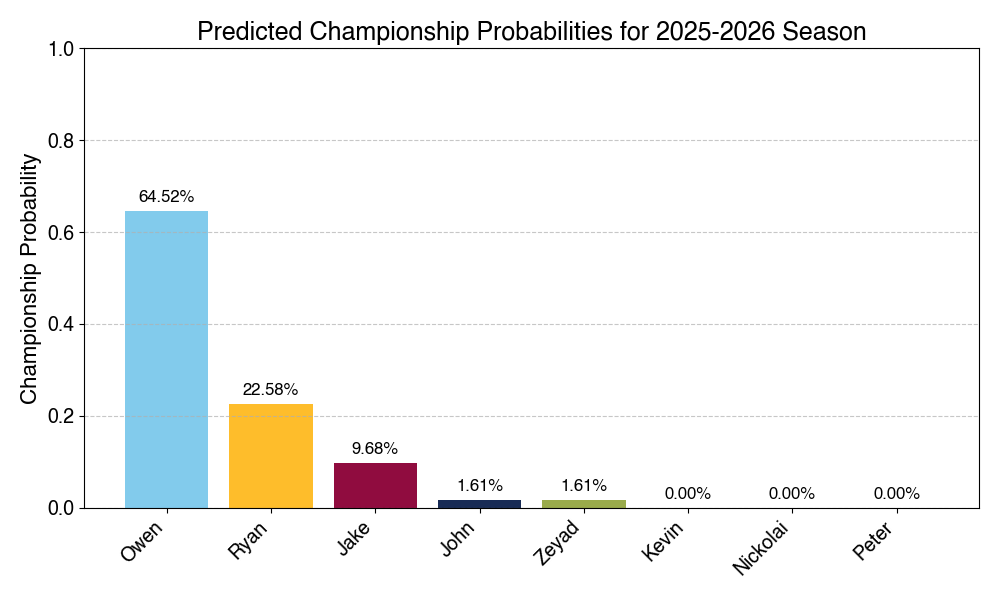

In [65]:
# =============================================================================
# 6. PREDICTING CHAMPIONSHIP PROBABILITIES BASED ON HISTORICAL AVERAGES
# =============================================================================

# Aggregate features by owner and take the mean across all 10 seasons
agg_features = final_week_df.groupby('owner')[features].mean()

# Predict probabilities by owner
predicted_probs = model.predict_proba(agg_features)[:, 1]  # Probability of winning the championship

# Normalize probabilities so that they add up to 100%
normalized_probs = predicted_probs / predicted_probs.sum()

predicted_df = pd.DataFrame({
    'owner': agg_features.index,
    'raw_predicted_prob': predicted_probs,
    'normalized_predicted_prob': normalized_probs
}).set_index('owner')



# =============================================================================
# 7. VISUALIZATION: NORMALIZED PREDICTED CHAMPIONSHIP PROBABILITIES
# =============================================================================

custom_hex_palette = [
    "#900c3f", "#182b55", "#5f4e94", "#a291c7",
    "#82cbec", "#d94f21", "#febd2b", "#9aab4b"
]

sorted_owners = sorted(predicted_df.index.tolist())
color_map = {owner: custom_hex_palette[i % len(custom_hex_palette)] for i, owner in enumerate(sorted_owners)}

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 14  

sorted_probs = predicted_df['normalized_predicted_prob'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(sorted_probs.index, sorted_probs.values, color=[color_map[owner] for owner in sorted_probs.index])

ax.set_ylabel("Championship Probability", fontsize=16)
ax.set_title("Predicted Championship Probabilities for 2025-2026 Season", fontsize=18)

ax.set_ylim(0, 1)

ax.set_xticks(range(len(sorted_probs.index)))
ax.set_xticklabels(sorted_probs.index, rotation=45, ha="right")

# text labels over bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2%}", 
            ha='center', fontsize=12, fontweight='bold', color='black')


ax.grid(axis="y", linestyle="--", alpha=0.7)


plt.tight_layout()
plt.show()



### Modeling championship probability via L2 logistic regression: what are the relationships between each statistic and championship probability?
* Here, we fit a mathematical equation to predict whether a team wins the championship and extract coefficient weights
* Positive coefficients are predictive of winning the championship while negative coefficients predict losing
    * historical stats are more predictive than season stats  

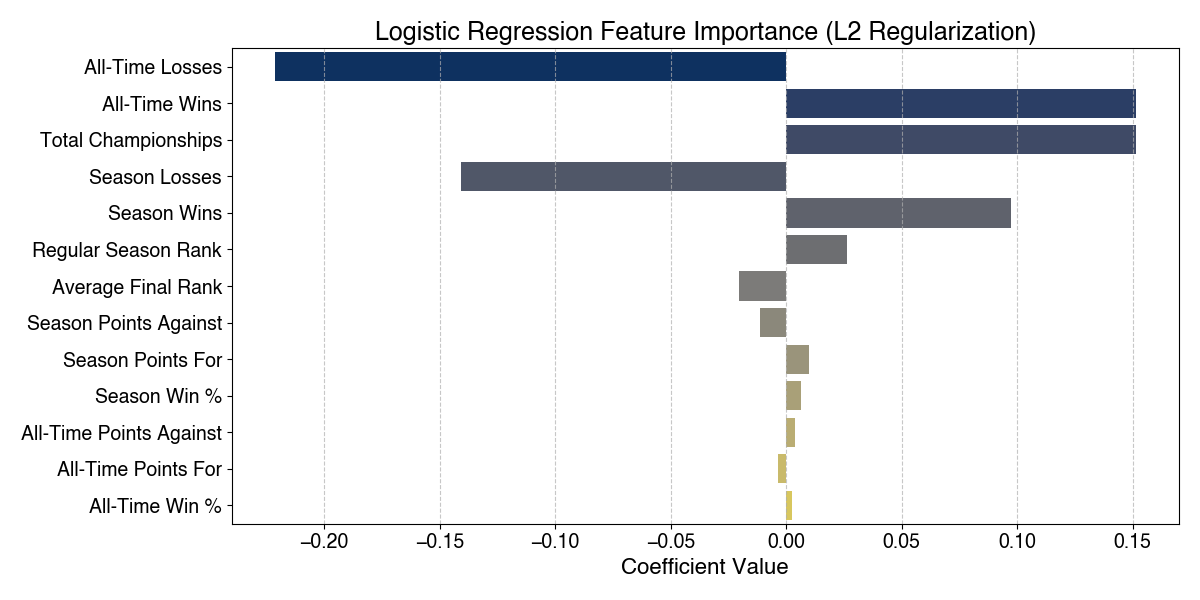

In [84]:

df = pd.read_csv('full_league_history.csv')

# Aggregate at season level
final_week_df = df.groupby(['season', 'owner']).apply(lambda x: x.loc[x['week'].idxmax()]).reset_index(drop=True)

final_week_df['champion'] = (final_week_df['final_rank'] == 1).astype(int)

# same features as previous model
features = [
    'szn_pts_for', 'szn_pts_against', 'szn_wins', 'szn_losses', 'szn_pct', 
    'all_time_pts_for', 'all_time_pts_against', 'all_time_wins', 'all_time_losses', 
    'all_time_pct', 'reg_szn_rank', 'avg_final_rank', 'championships'
]

X = final_week_df[features]
y = final_week_df['champion']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=77)

# Train Logistic Regression with L2 regularization
model = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
model.fit(X_train, y_train)

# Same performance evaluation
#y_pred = model.predict(X_test)
#acc = accuracy_score(y_test, y_pred)
#print(f"\nTest Accuracy: {acc*100:.2f}%")

#cv_scores = cross_val_score(model, X, y, cv=5)
#print("Cross-Validation Accuracy Scores:", cv_scores)
#print("Average CV Accuracy:", cv_scores.mean())

y_proba_cv = cross_val_predict(model, X, y, cv=5, method="predict_proba")[:, 1]
auc_score = roc_auc_score(y, y_proba_cv)
#print(f"AUC-ROC Score: {auc_score:.3f}")

#cm = confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Champion", "Champion"])
#disp.plot(cmap="Blues", values_format="d")
#plt.title("Confusion Matrix")
#plt.show()

# =============================================================================
# 7. COEFFICIENT IMPORTANCE PLOT
# =============================================================================

# Extract feature importance (coefficients)
importances = model.coef_[0]
indices = np.argsort(abs(importances))[::-1]

feature_labels = {
    "szn_pts_for": "Season Points For",
    "szn_pts_against": "Season Points Against",
    "szn_wins": "Season Wins",
    "szn_losses": "Season Losses",
    "szn_pct": "Season Win %",
    "all_time_pts_for": "All-Time Points For",
    "all_time_pts_against": "All-Time Points Against",
    "all_time_wins": "All-Time Wins",
    "all_time_losses": "All-Time Losses",
    "all_time_pct": "All-Time Win %",
    "reg_szn_rank": "Regular Season Rank",
    "avg_final_rank": "Average Final Rank",
    "championships": "Total Championships"
}


cleaned_feature_names = [feature_labels[feature] for feature in np.array(features)[indices]]

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 14  

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x=importances[indices], y=cleaned_feature_names, palette='cividis', ax=ax)

ax.set_xlabel("Coefficient Value", fontsize=16)
ax.set_title("Logistic Regression Feature Importance (L2 Regularization)", fontsize=18)

ax.grid(axis="x", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()


### Predict championship probabilities 

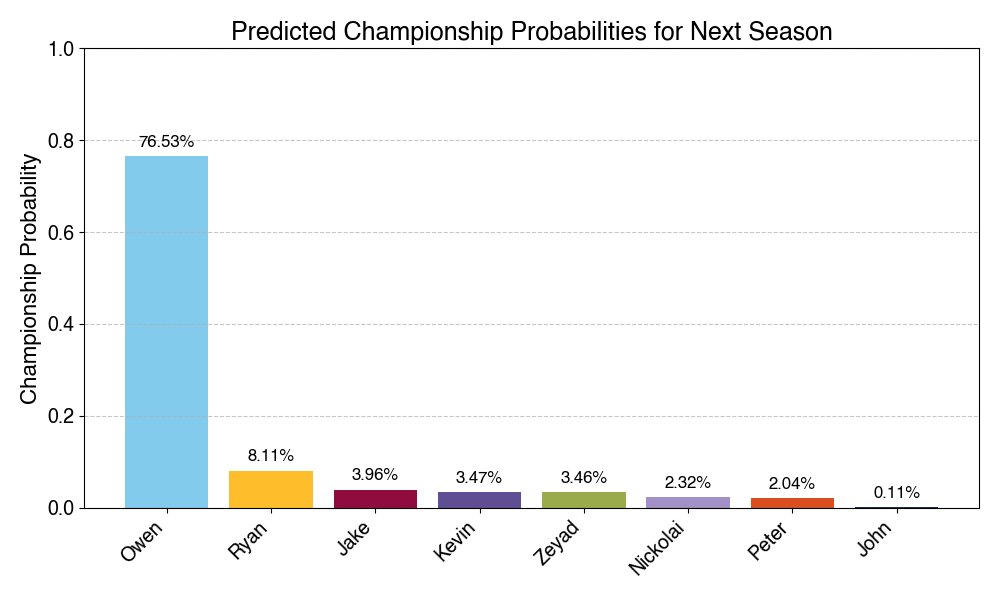

In [82]:

# =============================================================================
# 6. PREDICTING CHAMPIONSHIP PROBABILITIES BASED ON HISTORICAL AVERAGES
# =============================================================================

agg_features = final_week_df.groupby('owner')[features].mean()

predicted_probs = model.predict_proba(agg_features)[:, 1]  # Probability of winning the championship

normalized_probs = predicted_probs / predicted_probs.sum()

predicted_df = pd.DataFrame({
    'owner': agg_features.index,
    'raw_predicted_prob': predicted_probs,
    'normalized_predicted_prob': normalized_probs
}).set_index('owner')



# =============================================================================
# 7. GRAPH CHAMPIONSHIP PROBABILITIES
# =============================================================================

custom_hex_palette = [
    "#900c3f", "#182b55", "#5f4e94", "#a291c7",
    "#82cbec", "#d94f21", "#febd2b", "#9aab4b"
]

sorted_owners = sorted(predicted_df.index.tolist())
color_map = {owner: custom_hex_palette[i % len(custom_hex_palette)] for i, owner in enumerate(sorted_owners)}

plt.rcParams["font.family"] = "Helvetica"
plt.rcParams["font.size"] = 14  

sorted_probs = predicted_df['normalized_predicted_prob'].sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(sorted_probs.index, sorted_probs.values, color=[color_map[owner] for owner in sorted_probs.index])

ax.set_ylabel("Championship Probability", fontsize=16)
ax.set_title("Predicted Championship Probabilities for Next Season", fontsize=18)

ax.set_ylim(0, 1)

ax.set_xticks(range(len(sorted_probs.index)))
ax.set_xticklabels(sorted_probs.index, rotation=45, ha="right")


# Add text labels above bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.2%}", 
            ha='center', fontsize=12, fontweight='bold', color='black')

ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

